# Data Collection and Exploratory Data Analysis

The goal is to gather screenshots from NFL All-22 videos (YouTube) and use our fine-tuned model

In [1]:
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))
import logger

from src.data_collection import YouTubeScreenshotCollector

In [2]:
# List of dictionaries of video paths and youtube links:
videos = [
    {
        "video_csv_path": "video_csv/Video1.csv",
        "youtube_link": "https://www.youtube.com/watch?v=7ERkAhvmHCo"
    },
    {
        "video_csv_path": "video_csv/Video2.csv", 
        "youtube_link": "https://www.youtube.com/watch?v=221V_uAZ1Fg"
    },
    {
        "video_csv_path": "video_csv/Video3.csv",
        "youtube_link": "https://www.youtube.com/watch?v=GDR7QiUjbdw"
    },
    {
        "video_csv_path": "video_csv/Video4.csv",
        "youtube_link": "https://www.youtube.com/watch?v=Pp1jfEqHYxQ"
    },
    {
        "video_csv_path": "video_csv/Video5.csv",
        "youtube_link": "https://www.youtube.com/watch?v=dLbRF7oTl34"
    },
    {
        "video_csv_path": "video_csv/Video6.csv",
        "youtube_link": "https://www.youtube.com/watch?v=fvaaMcpQBSE"
    },
]


In [3]:
# Process all videos in the list
collector = YouTubeScreenshotCollector()

for i, video_info in enumerate(videos):
    print(f"\n--- Processing Video {i+1}/{len(videos)} ---")
    print(f"YouTube Link: {video_info['youtube_link']}")
    print(f"CSV Path: {video_info['video_csv_path']}")
    
    try:
        # Download video
        video_path = collector.download_youtube_video(video_info['youtube_link'])
        
        # Load timestamps from CSV
        timestamps, csv_filename = collector.load_timestamps_from_csv(video_info['video_csv_path'])
        print(f"Loaded {len(timestamps)} timestamps from {csv_filename}")
        
        # Process video and extract screenshots
        num_screenshots = collector.process_video_timestamps(video_path, timestamps, csv_filename)
        print(f"Generated {num_screenshots} screenshots")
        
        # Delete video to save disk space
        collector.delete_video(video_path)
        
        print(f"✅ Successfully processed {csv_filename}")
        
    except Exception as e:
        print(f"❌ Error processing video {i+1}: {e}")
        continue

print(f"\nFinished processing all {len(videos)} videos!")



--- Processing Video 1/6 ---
YouTube Link: https://www.youtube.com/watch?v=7ERkAhvmHCo
CSV Path: video_csv/Video1.csv
Extracting cookies from chrome
Extracted 3439 cookies from chrome
[youtube] Extracting URL: https://www.youtube.com/watch?v=7ERkAhvmHCo
[youtube] 7ERkAhvmHCo: Downloading webpage
[youtube] 7ERkAhvmHCo: Downloading tv client config
[youtube] 7ERkAhvmHCo: Downloading player 680f8c75-main
[youtube] 7ERkAhvmHCo: Downloading tv player API JSON
Extracting cookies from chrome
Extracted 3438 cookies from chrome
[youtube] Extracting URL: https://www.youtube.com/watch?v=7ERkAhvmHCo
[youtube] 7ERkAhvmHCo: Downloading webpage
[youtube] 7ERkAhvmHCo: Downloading tv client config
[youtube] 7ERkAhvmHCo: Downloading tv player API JSON
[info] 7ERkAhvmHCo: Downloading 1 format(s): 18
[download] Resuming download at byte 185503783
[download] Destination: /Users/lmarte/Documents/Projects/CU-Boulder/Deep_Learning/gridiron-ai/data/videos/2024 All 22 Coach film Wk 01 Chiefs vs Ravens.mp4
[dow

In [16]:
import sys
sys.path.append('../src')

import importlib
import feature_extraction
importlib.reload(feature_extraction)
from feature_extraction import FormationFeatureExtractor
import os
import json
import pandas as pd
from pathlib import Path
import numpy as np

# Initialize feature extractor
print("🚀 Initializing Feature Extractor...")
feature_extractor = FormationFeatureExtractor()

def extract_play_type_from_filename(filename, folder_name):
    """Extract play type from filename or use folder-based logic"""
    filename_lower = filename.lower()
    
    # Try to extract from filename first
    if filename_lower.startswith('run_') or 'run' in filename_lower:
        return 'run'
    elif filename_lower.startswith('pass_') or 'pass' in filename_lower:
        return 'pass'
    
    # If not clear from filename, return unknown for now
    return 'unknown'

def process_image_folder(folder_path, folder_name, dataset_split):
    """Process all images in a folder and extract features"""
    print(f"\n📂 Processing {folder_name} ({dataset_split}) folder...")
    
    if not folder_path.exists():
        print(f"   ⚠️ Folder not found: {folder_path}")
        return [], []
    
    # Get all image files
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
    image_files = []
    for ext in image_extensions:
        image_files.extend(folder_path.glob(ext))
    
    print(f"   Found {len(image_files)} images")
    
    features_list = []
    failed_list = []
    
    for i, image_path in enumerate(image_files):
        if i % 10 == 0:  # Progress update every 10 images
            print(f"   Processing {i+1}/{len(image_files)}: {image_path.name}")
        
        try:
            # Extract features
            features = feature_extractor.extract_features(str(image_path))
            
            if features is not None:
                # Add metadata
                features['filename'] = image_path.name
                features['dataset_split'] = dataset_split
                features['source_folder'] = folder_name
                features['play_type'] = extract_play_type_from_filename(image_path.name, folder_name)
                
                features_list.append(features)
            else:
                failed_list.append(image_path.name)
                
        except Exception as e:
            print(f"      ❌ Error processing {image_path.name}: {e}")
            failed_list.append(image_path.name)
    
    print(f"   ✅ Successfully processed: {len(features_list)} images")
    print(f"   ❌ Failed extractions: {len(failed_list)} images")
    
    return features_list, failed_list

# =============================================================================
# PROCESS ALL IMAGE SOURCES
# =============================================================================

print("🏈 COMPREHENSIVE FEATURE EXTRACTION")
print("=" * 50)

all_features = []
all_failed = []

# 1. Process YouTube Screenshots
print("\n1️⃣ YOUTUBE SCREENSHOTS")
screenshots_dir = Path("../data/youtube_screenshots")
youtube_features, youtube_failed = process_image_folder(screenshots_dir, "youtube_screenshots", "youtube")
all_features.extend(youtube_features)
all_failed.extend(youtube_failed)

# 2. Process Train/Valid/Test folders
data_folders = [
    ("../data/train/images", "train"),
    ("../data/valid/images", "valid"), 
    ("../data/test/images", "test")
]

for folder_path_str, split_name in data_folders:
    folder_path = Path(folder_path_str)
    print(f"\n{len(all_features)//1000 + 2}️⃣ {split_name.upper()} DATASET")
    
    split_features, split_failed = process_image_folder(folder_path, f"{split_name}_images", split_name)
    all_features.extend(split_features)
    all_failed.extend(split_failed)

# 3. Also check for alternative folder structures
alternative_folders = [
    ("../data/original/train/images", "train"),
    ("../data/original/valid/images", "valid"),
    ("../data/original/test/images", "test")
]

for folder_path_str, split_name in alternative_folders:
    folder_path = Path(folder_path_str)
    if folder_path.exists():
        print(f"\n📁 ALTERNATIVE {split_name.upper()} FOLDER")
        split_features, split_failed = process_image_folder(folder_path, f"original_{split_name}", split_name)
        all_features.extend(split_features)
        all_failed.extend(split_failed)

# =============================================================================
# FINAL RESULTS AND SAVING
# =============================================================================

print(f"\n🎉 EXTRACTION COMPLETE!")
print("=" * 50)
print(f"Total images processed: {len(all_features)}")
print(f"Total failed extractions: {len(all_failed)}")

if all_features:
    # Convert to DataFrame
    features_df = pd.DataFrame(all_features)
    print(f"\nFeature DataFrame shape: {features_df.shape}")
    print(f"Total features per image: {len([col for col in features_df.columns if col not in ['filename', 'dataset_split', 'source_folder', 'play_type']])}")
    
    # Summary by source
    print(f"\n📊 Summary by Source:")
    source_summary = features_df.groupby(['dataset_split', 'source_folder']).size()
    for (split, source), count in source_summary.items():
        print(f"   {split:10s} - {source:20s}: {count:4d} images")
    
    # Summary by play type
    print(f"\n🏈 Summary by Play Type:")
    play_type_summary = features_df.groupby(['dataset_split', 'play_type']).size()
    for (split, play_type), count in play_type_summary.items():
        print(f"   {split:10s} - {play_type:10s}: {count:4d} images")
    
    # Save comprehensive features
    features_csv_path = "../data/processed/comprehensive_features.csv"
    os.makedirs("../data/processed", exist_ok=True)
    features_df.to_csv(features_csv_path, index=False)
    print(f"\n💾 Features saved to: {features_csv_path}")
    
    # Save separate files by dataset split
    for split in features_df['dataset_split'].unique():
        split_df = features_df[features_df['dataset_split'] == split]
        split_path = f"../data/processed/features_{split}.csv"
        split_df.to_csv(split_path, index=False)
        print(f"   {split} features saved to: {split_path}")
    
else:
    print("❌ No features extracted successfully!")

if all_failed:
    print(f"\n⚠️ Failed files sample: {all_failed[:10]}")
    
    # Save failed files list
    failed_path = "../data/processed/failed_extractions.txt"
    with open(failed_path, 'w') as f:
        for failed_file in all_failed:
            f.write(f"{failed_file}\n")
    print(f"Failed files list saved to: {failed_path}")

🚀 Initializing Feature Extractor...
🏈 COMPREHENSIVE FEATURE EXTRACTION

1️⃣ YOUTUBE SCREENSHOTS

📂 Processing youtube_screenshots (youtube) folder...
   Found 66 images
   Processing 1/66: pass_0009_3295.jpg

image 1/1 /Users/lmarte/Documents/Projects/CU-Boulder/Deep_Learning/gridiron-ai/notebooks/../data/youtube_screenshots/pass_0009_3295.jpg: 384x640 18 defenses, 3 olines, 5 wide_receivers, 88.0ms
Speed: 0.6ms preprocess, 88.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/lmarte/Documents/Projects/CU-Boulder/Deep_Learning/gridiron-ai/notebooks/../data/youtube_screenshots/pass_0000_67.jpg: 384x640 13 defenses, 8 olines, 1 ref, 2 running_backs, 6 wide_receivers, 70.6ms
Speed: 0.5ms preprocess, 70.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/lmarte/Documents/Projects/CU-Boulder/Deep_Learning/gridiron-ai/notebooks/../data/youtube_screenshots/pass_0008_1443.jpg: 384x640 16 defenses, 5 olines, 1 ref, 3 wide_re

In [17]:
# FORMATION SIMILARITY LABELING
# Use similarity-based approach to predict play types for unknown images

import importlib
import label_transfer
importlib.reload(label_transfer)
from label_transfer import FormationSimilarityLabeler

print("🔮 FORMATION SIMILARITY LABELING")
print("=" * 50)

# Check current label distribution
print(f"\n📊 Current Play Type Distribution:")
label_counts = features_df['play_type'].value_counts()
print(label_counts)

unknown_count = label_counts.get('unknown', 0)
labeled_count = len(features_df) - unknown_count

if unknown_count == 0:
    print("\n✅ All images already have play type labels!")
else:
    print(f"\n🎯 Target: Predict labels for {unknown_count} unknown images using {labeled_count} labeled examples")
    
    # Initialize similarity labeler
    similarity_labeler = FormationSimilarityLabeler(similarity_threshold=0.8)
    
    # Prepare labeled data (known run/pass examples)
    labeled_data = []
    for _, row in features_df[features_df['play_type'].isin(['run', 'pass'])].iterrows():
        labeled_data.append({
            'filename': row['filename'],
            'play_type': row['play_type'],
            'features': row.to_dict()
        })
    
    # Prepare unlabeled data (unknown examples)
    unlabeled_data = []
    for _, row in features_df[features_df['play_type'] == 'unknown'].iterrows():
        unlabeled_data.append({
            'filename': row['filename'], 
            'features': row.to_dict()
        })
    
    print(f"\n🔄 Processing {len(unlabeled_data)} unknown images...")
    print(f"Using {len(labeled_data)} labeled examples as reference...")
    
    # Transfer labels
    prediction_results = similarity_labeler.transfer_labels(labeled_data, unlabeled_data)
    
    # Update the dataframe with predictions
    for filename, result in prediction_results.items():
        mask = features_df['filename'] == filename
        features_df.loc[mask, 'play_type'] = result['predicted_label']
        features_df.loc[mask, 'prediction_confidence'] = result['confidence']
        features_df.loc[mask, 'similarity_score'] = result['similarity_score']
    
    # Show results
    print(f"\n✅ LABELING COMPLETE!")
    print("-" * 30)
    
    # New distribution
    new_label_counts = features_df['play_type'].value_counts()
    print(f"\n📈 Updated Play Type Distribution:")
    for label, count in new_label_counts.items():
        change = count - label_counts.get(label, 0)
        change_str = f" (+{change})" if change > 0 else ""
        print(f"   {label:10s}: {count:4d}{change_str}")
    
    # Confidence breakdown
    if 'prediction_confidence' in features_df.columns:
        confidence_counts = features_df[features_df['prediction_confidence'].notna()]['prediction_confidence'].value_counts()
        print(f"\n🎯 Prediction Confidence Breakdown:")
        for conf, count in confidence_counts.items():
            print(f"   {conf:10s}: {count:4d} predictions")
    
    # Show some examples
    print(f"\n🔍 Sample Predictions:")
    predicted_examples = features_df[features_df['prediction_confidence'].notna()].head(10)
    for _, row in predicted_examples.iterrows():
        print(f"   {row['filename']:30s} → {row['play_type']:4s} (conf: {row['prediction_confidence']:6s}, sim: {row['similarity_score']:.3f})")
    
    # High confidence predictions
    high_conf_predictions = features_df[features_df['prediction_confidence'] == 'high']
    print(f"\n⭐ High Confidence Predictions: {len(high_conf_predictions)} images")
    
    # Low confidence predictions that might need manual review
    low_conf_predictions = features_df[features_df['prediction_confidence'] == 'low']
    if len(low_conf_predictions) > 0:
        print(f"\n⚠️ Low Confidence Predictions: {len(low_conf_predictions)} images")
        print("   These might benefit from manual review:")
        for _, row in low_conf_predictions.head(5).iterrows():
            print(f"   📋 {row['filename']} → {row['play_type']} (sim: {row['similarity_score']:.3f})")
    
    # Save updated features with predictions
    updated_csv_path = "../data/processed/comprehensive_features_labeled.csv"
    features_df.to_csv(updated_csv_path, index=False)
    print(f"\n💾 Updated features with predictions saved to: {updated_csv_path}")

print(f"\n📈 FINAL DATASET SUMMARY:")
print(f"Total images: {len(features_df)}")
print(f"Run plays: {len(features_df[features_df['play_type'] == 'run'])}")
print(f"Pass plays: {len(features_df[features_df['play_type'] == 'pass'])}")
remaining_unknown = len(features_df[features_df['play_type'] == 'unknown'])
if remaining_unknown > 0:
    print(f"Still unknown: {remaining_unknown}")
print(f"Dataset splits: {features_df['dataset_split'].value_counts().to_dict()}")


🔮 FORMATION SIMILARITY LABELING

📊 Current Play Type Distribution:
play_type
unknown    280
pass        36
run         30
Name: count, dtype: int64

🎯 Target: Predict labels for 280 unknown images using 66 labeled examples

🔄 Processing 280 unknown images...
Using 66 labeled examples as reference...

✅ LABELING COMPLETE!
------------------------------

📈 Updated Play Type Distribution:
   run       :  184 (+154)
   pass      :  162 (+126)

🎯 Prediction Confidence Breakdown:
   high      :  123 predictions
   medium    :   82 predictions
   low       :   75 predictions

🔍 Sample Predictions:
   58073_003389_Sideline_frame51_jpg.rf.2cfb4642415625f23cf051632716a23d.jpg → pass (conf: medium, sim: 0.761)
   Capture_PNG_jpg.rf.4a17b15578b25bf93736afae608616e6.jpg → pass (conf: high  , sim: 0.975)
   Capture78_PNG_jpg.rf.9c4000aec94e141631494b7fda42c510.jpg → pass (conf: high  , sim: 0.966)
   Capture179_PNG_jpg.rf.117be4fe0d2aedbd88abd062ea20c68c.jpg → pass (conf: medium, sim: 0.719)
   Capt

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
fig_size = (15, 10)

# Basic statistics comparison
print("🏈 FORMATION ANALYSIS: RUN vs PASS")
print("=" * 50)

print(f"\nDataset Overview:")
print(f"Total plays: {len(features_df)}")
print(f"Run plays: {len(features_df[features_df['play_type'] == 'run'])}")
print(f"Pass plays: {len(features_df[features_df['play_type'] == 'pass'])}")

# Get numerical features only
numerical_features = features_df.select_dtypes(include=[np.number]).columns.tolist()
if 'play_type' in numerical_features:
    numerical_features.remove('play_type')

print(f"\nTotal features extracted: {len(numerical_features)}")

# Summary statistics by play type
print(f"\n📊 Key Formation Differences (Run vs Pass):")
print("-" * 50)

key_features = [
    'personnel', 'rb_count', 'te_count', 'wr_count', 'qb_count',
    'formation_width', 'backfield_depth', 'is_empty_backfield', 'is_heavy_formation',
    'box_defenders', 'formation_symmetry', 'avg_wr_spacing', 'qb_rb_min_distance'
]

# Filter to only existing features
existing_key_features = [f for f in key_features if f in features_df.columns]

for feature in existing_key_features[:8]:  # Show first 8 key features
    if feature in numerical_features:
        run_mean = features_df[features_df['play_type'] == 'run'][feature].mean()
        pass_mean = features_df[features_df['play_type'] == 'pass'][feature].mean()
        
        # Statistical significance test
        run_data = features_df[features_df['play_type'] == 'run'][feature].dropna()
        pass_data = features_df[features_df['play_type'] == 'pass'][feature].dropna()
        
        if len(run_data) > 0 and len(pass_data) > 0:
            t_stat, p_value = stats.ttest_ind(run_data, pass_data)
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
            
            print(f"{feature:20s}: Run={run_mean:6.2f} | Pass={pass_mean:6.2f} | p={p_value:.3f} {significance}")
    else:
        # For categorical features
        run_mode = features_df[features_df['play_type'] == 'run'][feature].mode()
        pass_mode = features_df[features_df['play_type'] == 'pass'][feature].mode()
        
        run_val = run_mode.iloc[0] if len(run_mode) > 0 else "N/A"
        pass_val = pass_mode.iloc[0] if len(pass_mode) > 0 else "N/A"
        
        print(f"{feature:20s}: Run={run_val} | Pass={pass_val}")

print("\n* p < 0.05, ** p < 0.01, *** p < 0.001")



🏈 FORMATION ANALYSIS: RUN vs PASS

Dataset Overview:
Total plays: 346
Run plays: 184
Pass plays: 162

Total features extracted: 55

📊 Key Formation Differences (Run vs Pass):
--------------------------------------------------
personnel           : Run=20 | Pass=10
rb_count            : Run=  2.03 | Pass=  1.44 | p=0.001 ***
te_count            : Run=  0.03 | Pass=  0.00 | p=0.020 *
wr_count            : Run=  4.04 | Pass=  5.49 | p=0.000 ***
qb_count            : Run=  2.32 | Pass=  2.28 | p=0.928 
formation_width     : Run=209.97 | Pass=239.81 | p=0.008 **
backfield_depth     : Run= 14.66 | Pass=  4.51 | p=0.019 *
is_empty_backfield  : Run=False | Pass=False

* p < 0.05, ** p < 0.01, *** p < 0.001


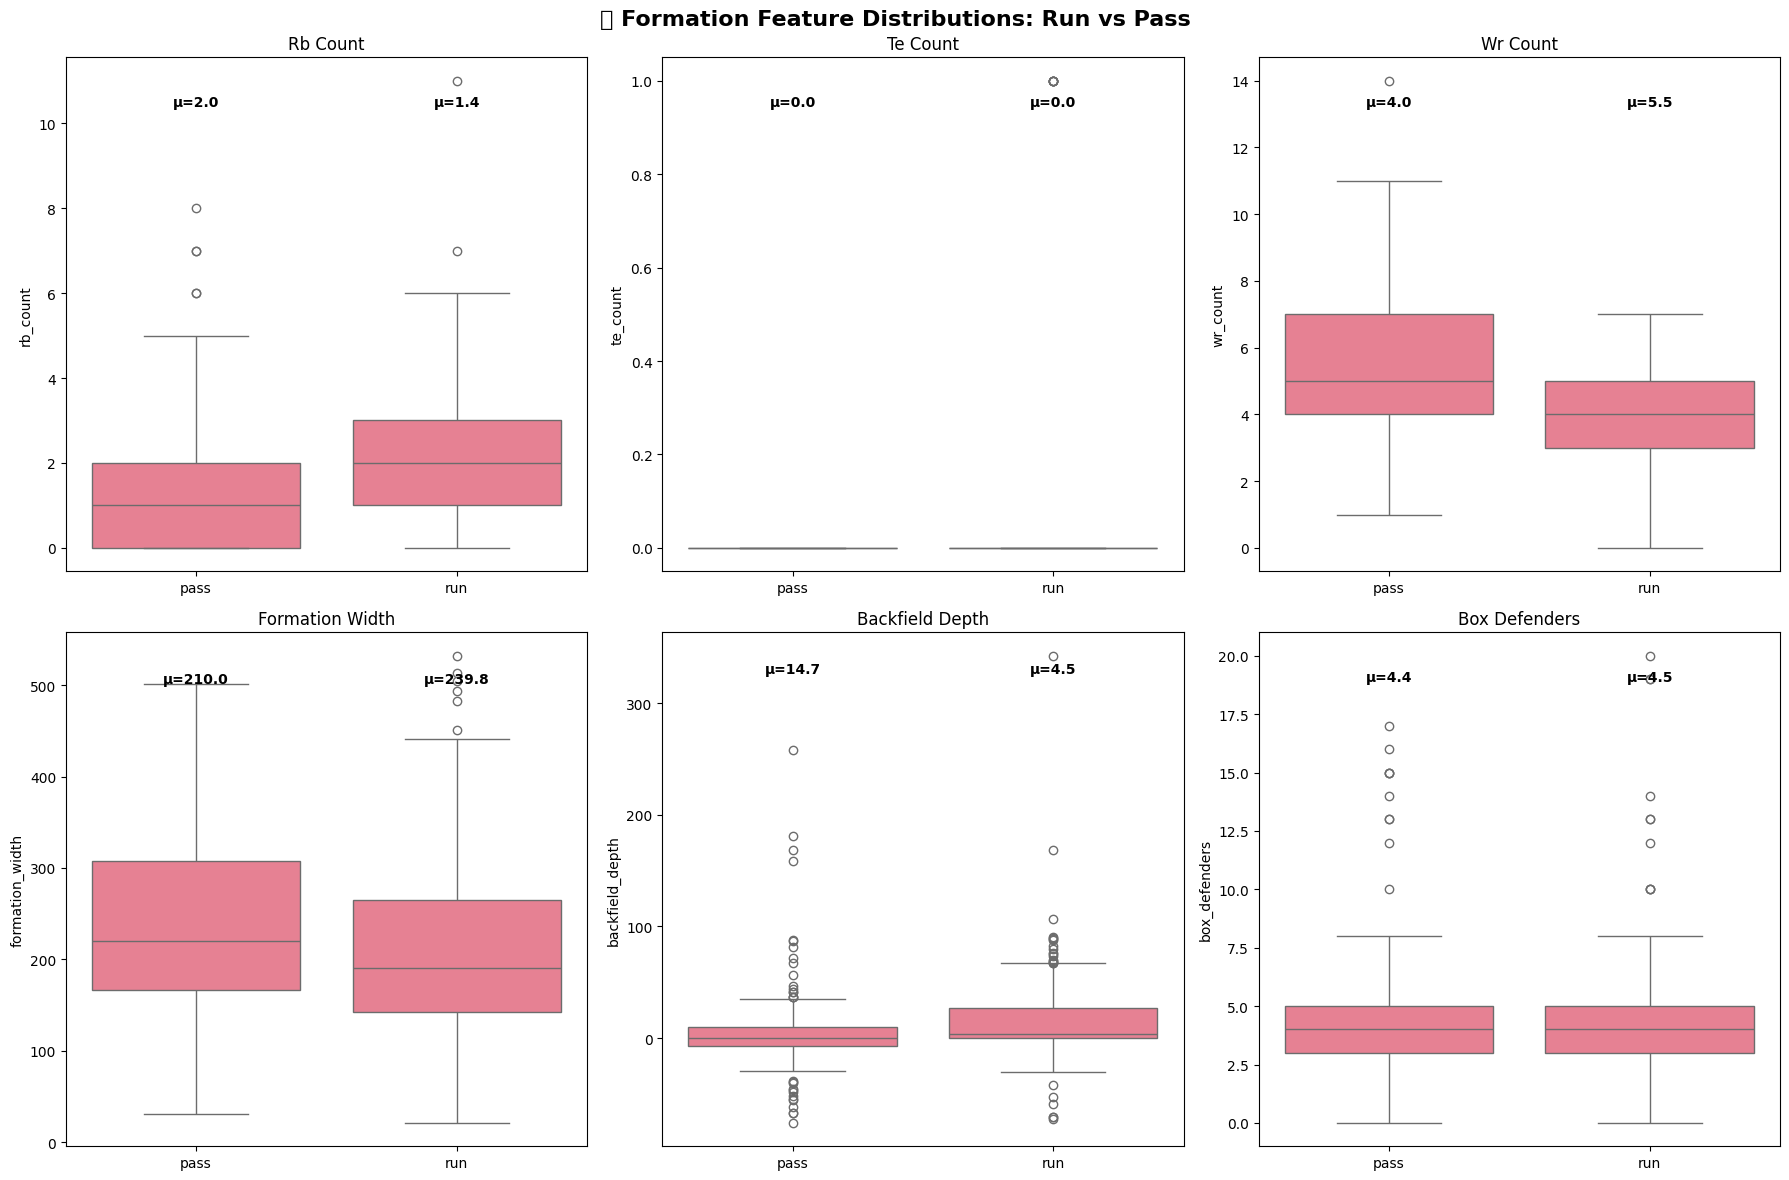

In [19]:
# 1. Distribution Comparisons for Key Features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('🏈 Formation Feature Distributions: Run vs Pass', fontsize=16, fontweight='bold')

key_plot_features = ['rb_count', 'te_count', 'wr_count', 'formation_width', 'backfield_depth', 'box_defenders']
existing_plot_features = [f for f in key_plot_features if f in features_df.columns]

for i, feature in enumerate(existing_plot_features[:6]):
    row, col = i // 3, i % 3
    ax = axes[row, col]
    
    # Box plot
    sns.boxplot(data=features_df, x='play_type', y=feature, ax=ax)
    ax.set_title(f'{feature.replace("_", " ").title()}')
    ax.set_xlabel('')
    
    # Add mean values as text
    run_mean = features_df[features_df['play_type'] == 'run'][feature].mean()
    pass_mean = features_df[features_df['play_type'] == 'pass'][feature].mean()
    ax.text(0, ax.get_ylim()[1]*0.9, f'μ={run_mean:.1f}', ha='center', fontweight='bold')
    ax.text(1, ax.get_ylim()[1]*0.9, f'μ={pass_mean:.1f}', ha='center', fontweight='bold')

# Remove empty subplots if any
for i in range(len(existing_plot_features), 6):
    row, col = i // 3, i % 3
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


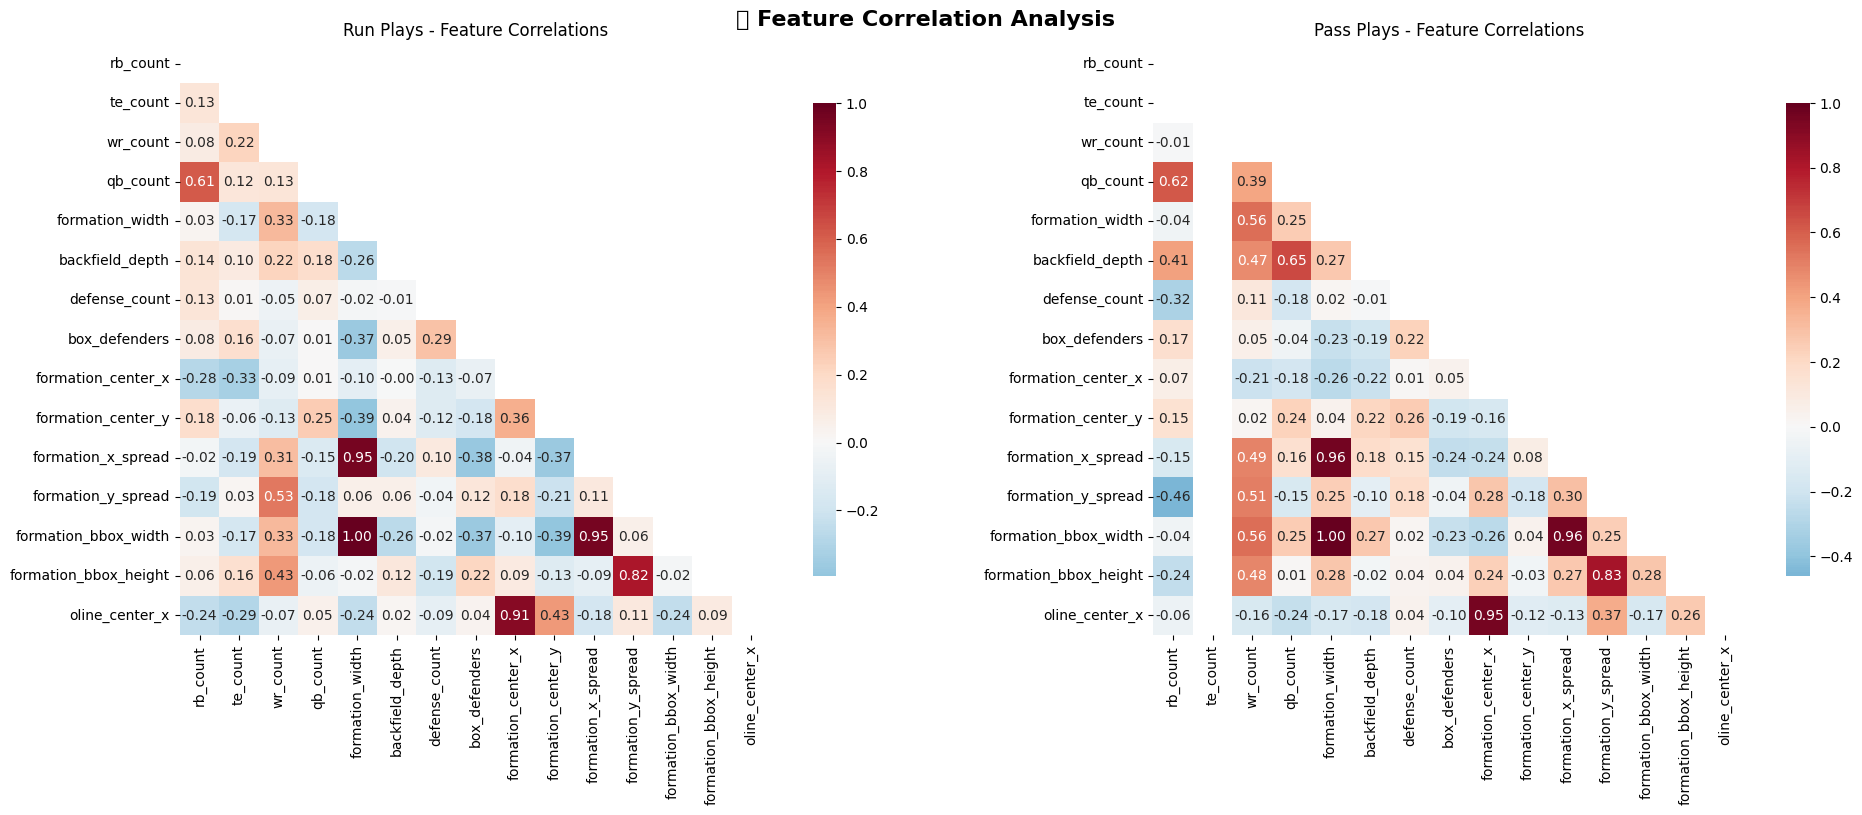

In [12]:
# 2. Correlation Analysis
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('🔗 Feature Correlation Analysis', fontsize=16, fontweight='bold')

# Select key features for correlation analysis
correlation_features = [f for f in numerical_features if f in features_df.columns][:15]  # Top 15 features

# Separate correlation matrices for run and pass
run_df = features_df[features_df['play_type'] == 'run'][correlation_features]
pass_df = features_df[features_df['play_type'] == 'pass'][correlation_features]

# Run correlation heatmap
if not run_df.empty:
    run_corr = run_df.corr()
    mask_run = np.triu(np.ones_like(run_corr, dtype=bool))
    sns.heatmap(run_corr, mask=mask_run, annot=True, cmap='RdBu_r', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8}, ax=axes[0])
    axes[0].set_title('Run Plays - Feature Correlations')

# Pass correlation heatmap
if not pass_df.empty:
    pass_corr = pass_df.corr()
    mask_pass = np.triu(np.ones_like(pass_corr, dtype=bool))
    sns.heatmap(pass_corr, mask=mask_pass, annot=True, cmap='RdBu_r', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8}, ax=axes[1])
    axes[1].set_title('Pass Plays - Feature Correlations')

plt.tight_layout()
plt.show()


🎯 FEATURE IMPORTANCE ANALYSIS


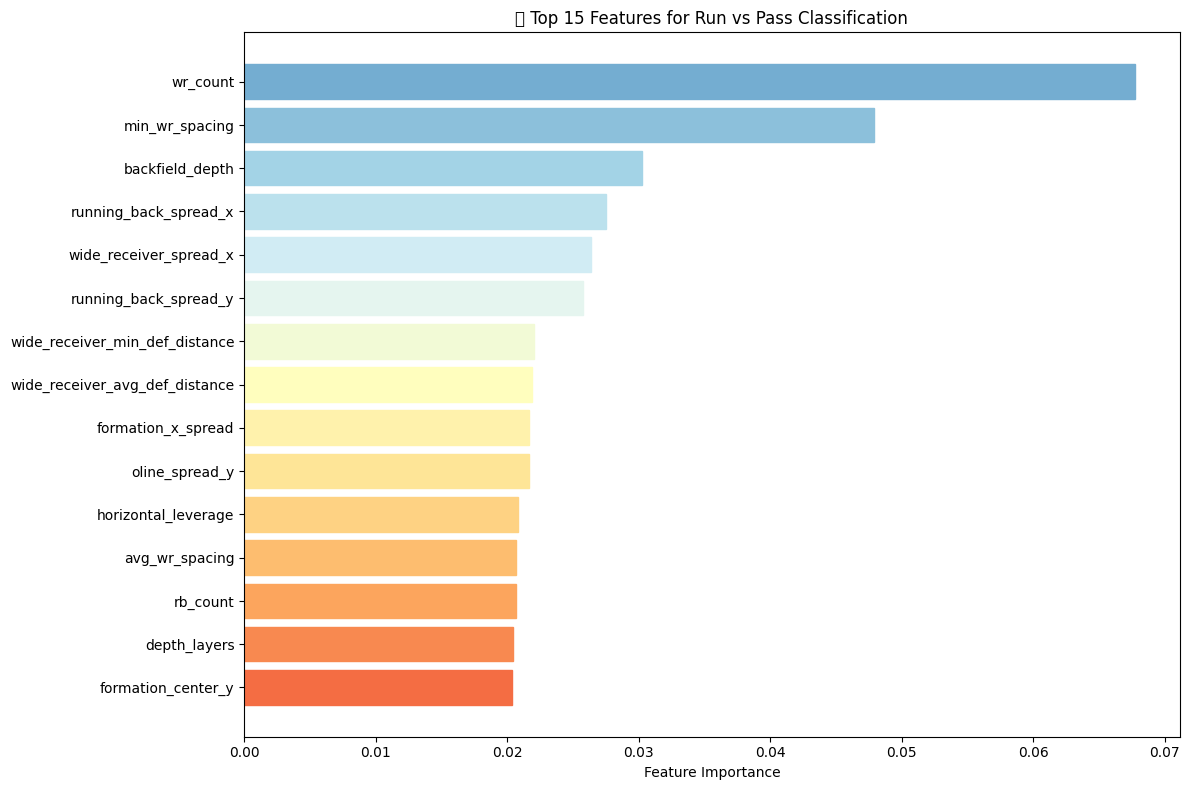


Top 10 Most Discriminative Features:
 1. wr_count                  (0.068)
 2. min_wr_spacing            (0.048)
 3. backfield_depth           (0.030)
 4. running_back_spread_x     (0.028)
 5. wide_receiver_spread_x    (0.026)
 6. running_back_spread_y     (0.026)
 7. wide_receiver_min_def_distance (0.022)
 8. wide_receiver_avg_def_distance (0.022)
 9. formation_x_spread        (0.022)
10. oline_spread_y            (0.022)

Cross-validation accuracy: 0.668 ± 0.039


In [ ]:
# 3. Feature Importance for Run vs Pass Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

print("🎯 FEATURE IMPORTANCE ANALYSIS")
print("=" * 40)

# Prepare data for classification
X = features_df[numerical_features].fillna(0)
y = features_df['play_type']

# Train Random Forest for feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 most important features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
bars = plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('🏆 Top 15 Features for Run vs Pass Classification')
plt.gca().invert_yaxis()

# Color bars based on importance
colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(top_features)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.tight_layout()
plt.show()

print(f"\nTop 10 Most Discriminative Features:")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:25s} ({row['importance']:.3f})")

# Classification accuracy
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf, X, y, cv=5)
print(f"\nCross-validation accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


In [23]:
# 7. Summary Insights & Conclusions
print("📋 FORMATION ANALYSIS SUMMARY")
print("=" * 50)

# Calculate effect sizes (Cohen's d) for key features
def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    pooled_std = np.sqrt(((n1-1)*group1.var() + (n2-1)*group2.var()) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

print("\n🔍 Effect Sizes (Cohen's d) - Large effects (>0.8):")
print("-" * 50)

large_effects = []
for feature in existing_key_features:
    if feature in numerical_features:
        run_data = features_df[features_df['play_type'] == 'run'][feature].dropna()
        pass_data = features_df[features_df['play_type'] == 'pass'][feature].dropna()
        
        if len(run_data) > 1 and len(pass_data) > 1:
            effect_size = abs(cohens_d(run_data, pass_data))
            if effect_size > 0.8:  # Large effect
                large_effects.append((feature, effect_size))
                direction = "Run > Pass" if run_data.mean() > pass_data.mean() else "Pass > Run"
                print(f"{feature:25s}: d = {effect_size:.2f} ({direction})")

if not large_effects:
    print("No features with large effect sizes (d > 0.8) found.")

# Key insights
print(f"\n💡 KEY INSIGHTS:")
print("-" * 30)

run_count = len(features_df[features_df['play_type'] == 'run'])
pass_count = len(features_df[features_df['play_type'] == 'pass'])

print(f"1. Dataset Balance: {run_count} run plays vs {pass_count} pass plays")

if 'rb_count' in features_df.columns:
    avg_rb_run = features_df[features_df['play_type'] == 'run']['rb_count'].mean()
    avg_rb_pass = features_df[features_df['play_type'] == 'pass']['rb_count'].mean()
    print(f"2. RB Usage: Run plays avg {avg_rb_run:.1f} RBs, Pass plays avg {avg_rb_pass:.1f} RBs")

if 'formation_width' in features_df.columns:
    avg_width_run = features_df[features_df['play_type'] == 'run']['formation_width'].mean()
    avg_width_pass = features_df[features_df['play_type'] == 'pass']['formation_width'].mean()
    width_diff = abs(avg_width_run - avg_width_pass)
    wider = "Pass" if avg_width_pass > avg_width_run else "Run"
    print(f"3. Formation Width: {wider} formations are {width_diff:.0f} pixels wider on average")

if cv_scores.mean() > 0.6:
    print(f"4. Predictability: {cv_scores.mean():.1%} classification accuracy suggests formations are predictive")
else:
    print(f"4. Predictability: {cv_scores.mean():.1%} accuracy suggests formations overlap significantly")

print(f"\n🎯 RECOMMENDATIONS:")
print("-" * 20)
print("1. Focus on features with high importance scores for ML models")
print("2. Consider spatial features for advanced formation analysis") 
print("3. Investigate formations with large effect sizes for tactical insights")
print("4. Combine multiple features for robust run/pass prediction")


📋 FORMATION ANALYSIS SUMMARY

🔍 Effect Sizes (Cohen's d) - Large effects (>0.8):
--------------------------------------------------
No features with large effect sizes (d > 0.8) found.

💡 KEY INSIGHTS:
------------------------------
1. Dataset Balance: 184 run plays vs 162 pass plays
2. RB Usage: Run plays avg 2.0 RBs, Pass plays avg 1.4 RBs
3. Formation Width: Pass formations are 30 pixels wider on average
4. Predictability: 66.8% classification accuracy suggests formations are predictive

🎯 RECOMMENDATIONS:
--------------------
1. Focus on features with high importance scores for ML models
2. Consider spatial features for advanced formation analysis
3. Investigate formations with large effect sizes for tactical insights
4. Combine multiple features for robust run/pass prediction
